# <p style="color:blue">Advanced Lane Detection</p>

In [56]:
import pickle
import cv2
import numpy as np
import collections 
import glob
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial as P
import matplotlib.image as mpimg
import os

## Helper Function and Classes

1. **Class HyperParameter** : is used to maintain hyperparameters used by functions. This makes it easy to tune the parameters on the fly without any chane in the code

2. **Class Save_Images** : is used to save all the images generated, initially in this dictionary and then in a pickle file. Saving it in pickle file gives advanatage to view the o/p images for analysis/debugging without rerunning the program 

3. **Class Line** : 
This class is used to maintain information about lane detection and curvature. This information can be used to average the curvature points to determine the next starting points for lane detection

In [57]:
class HyperParameters():
    def __init__(self):
        
        # TOPVIEW_PERSPECTIVE_TRANSFORM -- Those points are actualy x,y of the left and right lanes from straigh_lines1.jpg
        # Need to work this out to automate it
        self.HYPERPARAMETERS = {    "MAIN" : {"RUN" : "TESTRUN"},
                                    "PATH" : {"CALIB":"../camera_cal/",
                                              "TEST" :"../test_images/",
                                              "PICKLE":"../pickle_output/"
                                                  },
                                    "PICKLE_FILES" : {"CALIB" : "calibration_data.pickle",
                                                       "PARAMETERS" : "hyperparameters.pickle"
                                                     },
                                    "CAMERA_CALIBRATION" : {"CAMERAMATRIX" : np.zeros((3,3)),
                                                            "DISTORTIONCOEFF" : ()
                                                           },
                                    "CANNY" : {"LOW_THRESHOLD" : 80,
                                              "HIGH_THRESHOLD)": 240
                                              },
                                    "GAUSSIAN_BLUR" : {"KERNEL_SIZE" : 17
                                                      },
                                 
                                    "DETECT_AND_DRAW_CORNERS" : {"NX_CORNERS_PER_ROW": 9,
                                                             "NY_CORNERS_PER_COLUMN": 6,
                                                             "WINSIZE" : (10, 10),
                                                             "ZEROZONE" :( -1, -1 ),
                                                             "CRITERIA" : (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 40, 0.001)
                                                            },
                                     "TRANFORMATION_MATRICES" : {"LEFT_BOTTOM_CORNER" : [209, 719],
                                                                 "RIGHT__BOTTOM_CORNER" : [1114, 719],
                                                                 "LEFT_TOP_CORNER" : [601,445],
                                                                 "RIGHT_TOP_CORNER" :[682,445] 
                                                                 },
                                    "GRADIENT_THRESHOLD": {"GRAY_THRESH_MIN": 20,
                                                   "GRAY_THRESH_MAX": 100,
                                                   "HLS_S_THRESH_MIN": 120,
                                                   "HLS_S_THRESH_MAX": 255
                                                          },
                                    "GRADIENT_BY_COLOR_AND_FILTER" : {"SOBEL_KERNEL" : 3,
                                                                      "SOBEL_ABSX_MIN_THRESHOLD": 20,
                                                                      "SOBEL_ABSX_MAX_THRESHOLD": 100,
                                                                      "SOBEL_MAG_MIN_THRESHOLD": 30,
                                                                      "SOBEL_MAG_MAX_THRESHOLD": 100,
                                                                      "SOBEL_DIR_MIN_THRESHOLD": 1.3,
                                                                      "SOBEL_DIR_MAX_THRESHOLD": 1.7,
                                                                      "HLS_S_MIN_THRESHOLD" : 220,
                                                                      "HLS_S_MAX_THRESHOLD" : 255, 
                                                                      "RGB_R_MIN_THRESHOLD" : 220,
                                                                      "RGB_R_MAX_THRESHOLD" : 255,
                                                                      "RGB_G_MIN_THRESHOLD" : 200,
                                                                      "RGB_G_MAX_THRESHOLD" : 255
                                                                           },
                                    "INITIAL_FIT_POLYNOMIAL": {"NWINDOWS" : 9,
                                                               "MARGIN" : 100,
                                                               "MINPIX" : 50
                                                        },
                                    "FITPOLY_USING_PRIORFIT" : {"MARGIN" : 300},

                                    "MEASURE_CURVATURE_REAL" : {"Y_METERS_PER_PIXEL" : 30/720,
                                                                "X_METERS_PER_PIXEL" : 3.7/700
                                                               },
                                    "DRAW_FINAL_LANES" : {"ORGIMG_WEIGHT" : 1,
                                                          "WARPIMG_WEIGHT" : 0.3
                                                         },

                                    "HOUGH_TRANSFORM" : { "RHO" : 1,
                                                          "THETA" : np.pi/180,
                                                          "THRESHOLD" : 50,
                                                          "MIN_LINE_LENGTH" : 30,
                                                          "MAX_LINE_GAP" : 25
                                                        },
                                    }
    def get_paramDict(self,key):
        return self.HYPERPARAMETERS[key]
    
    def get_fullDict(self):
        return self.HYPERPARAMETERS

    def set_paramDict(self, updateDict):
        for key, value in updateDict.items():
            for k, v in value.items():
                if v is not None:
                    self.HYPERPARAMETERS[key][k] = v
                        
#. Define a class to receive the characteristics of each line detection                     
class Line():
    def __init__(self):  
        self.detected   = []                                # was the line detected in the last iteration?
        self.sanityCheckDict = []               # List of Dict - Left/Right TOP, BOTTOM, MID, and distances
        self.polyFitDataCurrent = []                        # current (left_fit, right_fit, left_fitx, right_fitx)
        self.ROCData   = []                                 # ROC and Car Center data
        self.polyFitDataQueue = collections.deque([])       # last n (left_fit, right_fit, left_fitx, right_fitx)
        self.pixelPositionsQueue = collections.deque([])    # leftx and rightx (pixels around polynomial)
        self.polyfitDataSum = None                          # For quick calculation of n data avg
        self.polyfitDataAvg  = None                         # Avg of left_fit, right_fit, left_fitx, right_fitx
        self.polyFitDiff = np.array([0,0,0], dtype='float') # difference in fit coefficients between last and new fits
        self.curvatureData = []
        self.frameCount = 0
        self.badFrames = 0
        
class Save_Images():
    def __init__(self):
        self.SAVED_IMAGES_DICT = {  "PATH"  :        {"CALIB":"../pickle_output/",
                                                      "TEST_OUTPUT":"../output_images/",
                                                      "TEST" :"../pickle_output/" },
                                    "PICKLE_FILES" : { "CALIB": "calibimages.pickle",
                                                       "TEST": "testimages.pickle"
                                                     },
                                     "CALIB_IMAGES": {"ORIGINAL":[],
                                                      "WITHCORNERS" :[]  
                                                     },
                                      "TEST_IMAGES"  : {}
                                }
        
    def save_images_dict(self, key1, key2, value):
        self.SAVED_IMAGES_DICT[key1][key2].append(value)

    def get_imageDict(self, key):
        return self.SAVED_IMAGES_DICT[key]
    


def tune_hyper_paramters(func_name,paramInstance, **kwargs):
    """
    sets the parameters values of functions in the class Parameters
    """
    updateDict = {func_name : {**kwargs}}
    paramInstance.set_paramDict(updateDict)
        
def grayscale(img):
    """Applies the Grayscale transform
        This will return an image with only one color channel
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, paramInstance, key):
    """Applies a Gaussian Noise kernel"""
    paramDict = paramInstance.get_paramDict(key)
    kernel_size = paramDict["KERNEL_SIZE"]
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def draw_region_of_interest(originalImage):
    return cv2.polylines(originalImage,np.int32(np.array([[left,apex_left,apex_right,right]])),True,(0,0,255),10)


def rectangle_diagonal_points(n, staticData, leftCenter, rightCenter):
    imageHeight, windowHeight, margin = staticData
    y_low  = imageHeight - ((n+1) * windowHeight)
    y_high = imageHeight - (n * windowHeight)
    xleft_low = leftCenter - margin
    xleft_high = leftCenter + margin
    xright_low = rightCenter - margin
    xright_high = rightCenter + margin
    leftDiagonalPts  = [(xleft_low, y_low ), (xleft_high, y_high)]
    rightDiagonalPts = [(xright_low, y_low ), (xright_high, y_high)]
    return leftDiagonalPts, rightDiagonalPts

def nonZeroPixelsInWindow(nonzerox, nonzeroy, diagonalPoints):
    """
    Identifies the nonzero pixels in x and y within the window 
    """
    x_low, y_low = diagonalPoints[0]
    x_high, y_high = diagonalPoints[1]

    indices = ((nonzeroy >= y_low) & 
                 (nonzeroy < y_high) & 
                 (nonzerox >= x_low) & 
                 (nonzerox < x_high)).nonzero()[0]  ## get all left indices
    return indices
 
def extract_pixel_positions(nonZeroX, nonZeroY ,left_lane_inds, right_lane_inds):
    leftx = nonZeroX[left_lane_inds]
    lefty = nonZeroY[left_lane_inds] 
    rightx = nonZeroX[right_lane_inds]
    righty = nonZeroY[right_lane_inds]
    
    return (leftx, lefty, rightx, righty)

def recenter_window(currentCenter, nonZeroX, good_indices, minpix):
    if len(good_indices) > minpix:
        return np.int(np.mean(nonZeroX[good_indices]))
    return currentCenter
 
def evaluate_polynomial_func(fitData, Y, degree):
    """
    y-axis points => ploty
    x-axis points => f(y) => A*Y**2 + B*Y + C
    """
    A = fitData[2]
    B = fitData[1]
    C = fitData[0]
    
    if degree == 2:
        try:
            fitx =  (A * Y**2) + (B * Y) + C                # X = f(Y) = AY^2 + BY + C

        except TypeError:
            print('The function failed to fit a line! Applied work-around')
            fitx = (1 * Y**2) + (1 * Y)                     # X = f(Y) = Y^2 + Y
    
    elif degree == 1:
        numerator = (1 + (((2 * A * Y) + B) ** 2)) ** (3/2)  # X = f(Y) = { [(1 + (2AY + B)^2]^3/2 } / (|2A|)
        denominator = np.absolute(2 * A)
        fitx = numerator/denominator
    return fitx
    
def get_polyfit_data(pixelPositions, ploty):
    leftx, lefty, rightx, righty = pixelPositions
    
    left_fit  = P.polyfit(lefty, leftx, 2)
    right_fit = P.polyfit(righty, rightx, 2)
    left_fitx  = evaluate_polynomial_func(left_fit, ploty, 2)
    right_fitx = evaluate_polynomial_func(right_fit, ploty, 2)
    
    return (left_fit, right_fit, left_fitx, right_fitx) 

def create_out_img_for_visual(binary_warped, visual_data):
    pixelPositions, polyfitData,nonZeroY, nonZeroX, left_lane_inds, right_lane_inds, margin, ploty =  visual_data
    left_fitx, right_fitx = (polyfitData[2], polyfitData[3])
    out_img_2 = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Color in left and right line pixels
    out_img_2[nonZeroY[left_lane_inds], nonZeroX[left_lane_inds]] = [255, 0, 0]
    out_img_2[nonZeroY[right_lane_inds], nonZeroX[right_lane_inds]] = [0, 0, 255]
    return out_img_2
    
def create_polyfill_outimg_for_visual(fname, binary_warped, visual_data, testImagesInstance, mode):
    """
    Generate a polygon to illustrate the search window area
    And recast the x and y points into usable format for cv2.fillPoly()
    """
    pixelPositions, polyfitData,nonZeroY, nonZeroX, left_lane_inds, right_lane_inds, margin, ploty =  visual_data
    left_fitx, right_fitx = (polyfitData[2], polyfitData[3])
    out_img_2 = create_out_img_for_visual(binary_warped, visual_data)
    window_img = np.zeros_like(out_img_2)
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    polyLineImg = cv2.addWeighted(out_img_2, 1, window_img, 0.3, 0)
    
    polyLineData = [polyLineImg, left_fitx, right_fitx, ploty]
    if mode == "TESTRUN":
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["POLYLINE_IMGS"] = polyLineData
    return polyLineImg


def pickle_load(filename):
    with open(filename, 'rb') as f:
        pickleDict = pickle.load(f)
    
    return pickleDict

def pickle_dump(filename, inputDict):
    """
    filename is fullpath : eg ../pickle_output/calibImages.pickle
    """
    with open(filename, 'wb') as f:
        pickle.dump(inputDict, f)

def unpickle_calibration_data(filename):
    with open(filename, 'rb') as f:
        calibrationData = pickle.load(f)
        return (calibrationData["CAMERAMATRIX"], calibrationData["DISTORTIONCOEFF"])

def pickledump_calib_images(calibImagesInstance):
    """
    Pickle all generated images for anytime viewing
    """
    calibDir = calibImagesInstance.get_imageDict("PATH")["CALIB"]
    calibFilename = calibImagesInstance.get_imageDict("PICKLE_FILES")["CALIB"]
    calibImagesDict = calibImagesInstance.get_imageDict("CALIB_IMAGES")
    pickle_dump(calibDir + calibFilename, calibImagesDict)
    
def pickledump_test_images(testImagesInstance):
    """
    Pickle all generated images for anytime viewing
    """
    testDir = testImagesInstance.get_imageDict("PATH")["TEST"]
    testFilename = testImagesInstance.get_imageDict("PICKLE_FILES")["TEST"]
    testImagesDict = testImagesInstance.get_imageDict("TEST_IMAGES")
    pickle_dump(testDir + testFilename, testImagesDict)
    
def pickledump_all_Hyperparameters(paramInstance):
    """
    Pickle all Hyperparameters - This is expected Tuned Parameters required for ProdRun
    """
    allHyperparamDict = paramInstance.get_fullDict()
    picklePath = allHyperparamDict["PATH"]["PICKLE"]
    pickleFile = allHyperparamDict["PICKLE_FILES"]["PARAMETERS"]
    filename = picklePath + pickleFile
    pickle_dump(filename, allHyperparamDict)
    
    # seperately dump Calibration dump
    calibDir = paramInstance.get_paramDict("PATH")["PICKLE"]
    calibFile = paramInstance.get_paramDict("PICKLE_FILES")["CALIB"] 
    calibrationDict = paramInstance.get_paramDict("CAMERA_CALIBRATION")
    pickle_dump(calibDir + calibFile, calibrationDict)
    

def cleanupOutputFiles():
    """
    Cleanup all the files
    """
    #pickleDir = calibImagesInstance.get_imageDict("PATH")["CALIB"]
    pickleFiles = glob.glob("../pickle_output/*.pickle")
    for filename in pickleFiles:
        os.remove(filename)
        
def pickledump_test_images(testImagesInstance):
    """
    Pickle all generated images for anytime viewing
    """
    testDir = testImagesInstance.get_imageDict("PATH")["TEST"]
    testFilename = testImagesInstance.get_imageDict("PICKLE_FILES")["TEST"]
    testImagesDict = testImagesInstance.get_imageDict("TEST_IMAGES")
    pickle_dump(testDir + testFilename, testImagesDict)    

def displayAndSaveImage(testImagesInstance, imageName,postfix, image, grayscale,  fitPoints, Ydata):
    testoutputPath= testImagesInstance.get_imageDict("PATH")["TEST_OUTPUT"]

    if imageName != "*.jpg":
        
        if postfix == "Histogram":
            plt.figure(figsize=(7,7))
            plt.plot(image)
            image = image * 255
        elif postfix == "Combined":
            plt.figure(figsize=(12,12))
            image = np.dstack((image*255,image*255,image*255))
            plt.imshow(image)
        elif grayscale:
            plt.figure(figsize=(12,12))
            #plt.figure(figsize=(12,12))
            plt.imshow(image, cmap='gray')
        else:
            plt.figure(figsize=(12,12))
            #plt.figure(figsize=(12,12))
            plt.imshow(image)
            if fitPoints is not None and Ydata is not None:
                left_fitx, right_fitx = fitPoints
                plt.plot(left_fitx, Ydata, color='yellow')
                plt.plot(right_fitx, Ydata, color='yellow')
                plt.xlim([0, 1280])
                plt.ylim([720, 0])
        plt.title(postfix, fontsize=24, fontweight=25)
        plt.show
        newfilename = imageName.replace(".jpg", "") + "_" + postfix + ".jpg" 
        if not (postfix == "Histogram"):
            cv2.imwrite(testoutputPath + newfilename, image)
        else:
              plt.savefig(testoutputPath + newfilename, dpi = (50))  
            


# <p style="color:blue"> Pipleline Steps </center> </p>

## Step-1-A:  Camera Calibration

**camera_calibration :** This is First function called during the run. Before processing the images it is necessary to calibrate the camera. This function returns few parameter of which **Camera Matrix and Distortion Coefficients** are the ones which will be used to **undistort** every frame/image

**detect_and_draw_corners :** called by **camera_calibration** function. It processes all chessboard images from the "../camera_cal/ directory and detects corners in those images which then helps to build the necessary image points required by the **camera_calibration** function

_camera calibration function is called from the initialize env function defined in next cell_

In [58]:
def detect_and_draw_corners(path, paramInstance, key,  calibImagesInstance):
    paramDict = paramInstance.get_paramDict(key)
    nx = paramDict["NX_CORNERS_PER_ROW"]
    ny = paramDict["NY_CORNERS_PER_COLUMN"]
    
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    imgPoints = []
    objPoints = []
    
    for filename in glob.glob(path + "*.jpg"):
        originalImage = mpimg.imread(filename)
        calibImagesInstance.save_images_dict("CALIB_IMAGES", "ORIGINAL", [filename,originalImage])
        distortedImage = np.copy(originalImage)
        grayImage = cv2.cvtColor(originalImage, cv2.COLOR_RGB2GRAY)
        imgSize = grayImage.shape[::-1]
        ret, corners = cv2.findChessboardCorners(grayImage, (nx, ny), None)
        if ret:
            winSize  = paramDict["WINSIZE"]
            zeroZone = paramDict["ZEROZONE"]
            criteria = paramDict["CRITERIA"]
            corners  = cv2.cornerSubPix( grayImage, corners, winSize, zeroZone, criteria );
            cv2.drawChessboardCorners(distortedImage, (nx, ny), corners, ret)
            imgPoints.append(corners)
            objPoints.append(objp)
            calibImagesInstance.save_images_dict("CALIB_IMAGES", "WITHCORNERS",[filename,distortedImage])
           
    return imgSize, imgPoints, objPoints
            
               
def camera_calibration(path, paramInstance, key, calibImagesInstance):
    """
    returnedTuple = (success, cameraMatrix, distortionCoeff, rvecs, tvecs)
    """
    paramDict = paramInstance.get_paramDict(key)
    imgSize, imgPoints, objPoints = detect_and_draw_corners(path, paramInstance, "DETECT_AND_DRAW_CORNERS", calibImagesInstance)
    returnedTuple =  cv2.calibrateCamera(objPoints, imgPoints, imgSize, None, None)
    
    success = returnedTuple[0]
    cameraMatrix = returnedTuple[1]
    distortionCoeff = returnedTuple[2]
 
    if success:
        updateDict = {"CAMERA_CALIBRATION" : {"CAMERAMATRIX" : cameraMatrix,
                                              "DISTORTIONCOEFF" : distortionCoeff
                                            }
                     }
        pickledump_calib_images(calibImagesInstance)
        paramInstance.set_paramDict(updateDict)
    else:
        print("Something wrong with Calibration!!")
        raise
        
    return cameraMatrix, distortionCoeff
    

# Step-1-B: Initialize the environment

**initialize_env**
This is the first function called in the pipeline. We create instances of the 3 classes: HyperParameter, Line and the Save_images classes. We then generate the Camera Matrix and Distortion coeeficients. The calibration data is either read from the existing pickle file **calibration_data.pickle**, if it exists or it is generated by calling the **camera_calibration**. **calibration_data.pickle** is created to avoid calling the **camera_calibration** function for every frame.

The 3 classes instances and the Calibration data once set from this function will act as Global variables for the rest of the functions

In [43]:
def initialize_env():
    paramInstance = HyperParameters()
    lineInstance = Line()
    testImagesInstance = Save_Images()

    dirDict = paramInstance.get_paramDict("PATH")
    fileDict = paramInstance.get_paramDict("PICKLE_FILES")
    calibPickleFile = dirDict["PICKLE"] + fileDict["CALIB"] 
    calibImagesPath = dirDict["CALIB"]
    if (not os.path.exists(calibPickleFile)):
        cameraMatrix, distortionCoeff = camera_calibration(calibImagesPath, paramInstance, "CAMERA_CALIBRATION", testImagesInstance)
        updateDict = {"CAMERA_CALIBRATION" : {"CAMERAMATRIX" : cameraMatrix,
                                              "DISTORTIONCOEFF" : distortionCoeff
                                            }
                     }
        pickle_dump(calibPickleFile, updateDict)
        paramInstance.set_paramDict(updateDict)
    else:
        cameraMatrix, distortionCoeff = unpickle_calibration_data(calibPickleFile)
        updateDict = {"CAMERA_CALIBRATION" : {"CAMERAMATRIX" : cameraMatrix,
                                              "DISTORTIONCOEFF" : distortionCoeff
                                            }
                     }
        paramInstance.set_paramDict(updateDict)
    return paramInstance, lineInstance, testImagesInstance, cameraMatrix, distortionCoeff


## Step-2: Undistort Image
**undistort_image :** This function uses the Calibration data (_cameraMatrix, distortionCoeff_) generated in Step-1 to undistort the image/frame

In [24]:
def undistort_image(image, cameraMatrix, distortionCoeff):
    return cv2.undistort(image, cameraMatrix, distortionCoeff, None, cameraMatrix)

## Step-3: Perspective Transformation
**tranformation_matrices:** To tranform perspective of an image, we need transformation Matrix _M_<br> 
This function helps to generate this M matrix along with the inverse of it _Minv_ which helps to transform back to original image.
This function only needs to be called once. Same M and Minv is used for all images/frames

**topview_perspective_transform:** Is the main function used apply transformation to the undistorted image from Step-2. It uses the **M** matrix generated by transformation_matrices function

In [25]:
def tranformation_matrices(imgSize, paramInstance, key):
    """
    This function needs to be evaluated once
    It is assumed that the imgSize will remain constant for all Test Images and VideoFrames
    """
    paramDict = paramInstance.get_paramDict(key)
    left= paramDict["LEFT_BOTTOM_CORNER"]
    right=paramDict["RIGHT__BOTTOM_CORNER"] 
    apex_left=paramDict["LEFT_TOP_CORNER"]
    apex_right=paramDict["RIGHT_TOP_CORNER"] 

    height, width = imgSize
    X_offset = width//5
    Y_offset = 0
    
    src=np.float32([left,apex_left,apex_right,right]) 
    dst = np.float32([[X_offset, height], [X_offset, Y_offset], [width - X_offset, Y_offset],[width - X_offset, height]])
    M = cv2.getPerspectiveTransform(src, dst)
    MInv = cv2.getPerspectiveTransform(dst, src)
    return M, MInv


def topview_perspective_transform(image, M, warpImgSize, paramInstance, key): 
    """
    Create top view of the lanes
    """
    warpedImage = cv2.warpPerspective(image, M, warpImgSize, flags=cv2.INTER_LINEAR)
    return warpedImage


## Step-4: Apply Color and Gradient Filter to detect White and Yellow Lane Lines
**gradient_by_color_and_filter :** This is the main function called for this step. Rest are helper functions.
After analyzing RGB, HSV and HLS colors, Red, Green and Saturation channel were used to detect the yellow and white color lane edges
On the gradient side I used Sobel Filter to generate three binaries : Absolute Gradient in X-direction, Magnitude in X-Y direction and the Direction of the edges

In [7]:
def get_channel_binary(channel_img, paramDict, imgType="RGB", channel_color='R'):
    prefix = imgType + "_" + channel_color
    thresh = (paramDict[prefix + "_MIN_THRESHOLD"], paramDict[prefix + "_MAX_THRESHOLD"])
    
    channel_binary = np.zeros_like(channel_img)
    channel_binary[(channel_img >= thresh[0]) & (channel_img <= thresh[1])] = 1
    
    return channel_binary

def get_color_channel_binaries(img, paramDict):
    """
    img is original Warped color image - 
    by default it is RGB since we used mpimg.imread to read the original image
    For project, will be using only R, G and S channels for detection of lane lines
    As they give better results for White and Yellow lanes
    """
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    R, G, B  = (img[:,:,0], img[:,:,1], img[:,:,2])  # using B only for Analysis
    H, L, S  = (HLS[:,:,0], HLS[:,:,1], HLS[:,:,2])
    R_binary = get_channel_binary(R, paramDict, imgType="RGB",channel_color='R')
    G_binary = get_channel_binary(G, paramDict, imgType="RGB",channel_color='G')
    S_binary = get_channel_binary(S, paramDict, imgType="HLS",channel_color='S')
    
    return R, G, B, H, L, S, R_binary, G_binary, S_binary

def get_sobel_binary(gray, paramDict, orient='X', flag='ABS'):
    if flag == "ABS":
        flag += orient
    
    sobel_kernel = paramDict["SOBEL_KERNEL"]
    
    thresh = (paramDict["SOBEL_"+flag+"_MIN_THRESHOLD"], paramDict["SOBEL_"+flag+"_MAX_THRESHOLD"])
    
    gradientx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    gradienty = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    if (flag == "ABSX"):
        value = np.absolute(gradientx)
    elif (flag == "ABSY"):
        value = np.absolute(gradienty)
    elif flag == "MAG":
        value = np.sqrt((gradientx ** 2) + (gradienty ** 2))
    elif flag == "DIR":
        value = np.arctan2(np.absolute(gradienty), np.absolute(gradientx))
        
    if flag == "DIR" :
        scaled_sobel = value
    else:
        scaled_sobel = np.uint8(255*value / np.max(value))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(value >= thresh[0]) & (value <= thresh[1])] = 1
    
    return binary_output

def gradient_by_color_and_filter(fname, warpedImage, paramInstance, key, testImagesInstance, mode): 
    paramDict = paramInstance.get_paramDict(key)
    gray = cv2.cvtColor(warpedImage, cv2.COLOR_RGB2GRAY)
    grayBlur = gaussian_blur(gray, paramInstance, "GAUSSIAN_BLUR")
    
    RGSImages = get_color_channel_binaries(warpedImage, paramDict)
    R, G, B, H, L, S, R_binary, G_binary, S_binary = RGSImages
    sobelx_binary = get_sobel_binary(grayBlur,  paramDict, orient='X', flag = 'ABS')
    mag_binary = get_sobel_binary(grayBlur, paramDict, orient='X', flag = 'MAG')
    dir_binary = get_sobel_binary(grayBlur, paramDict, orient='X', flag = 'DIR')
    
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(sobelx_binary == 1 ) | ((mag_binary == 1) & (dir_binary == 1)) |
                    (R_binary == 1) | (G_binary == 1)  | (S_binary == 1)] = 1
    
    if mode == "TESTRUN":
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["GRAY"] = gray
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["GRAY_BLUR"] = grayBlur
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["R_CHANNEL"] = R
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["G_CHANNEL"] = G
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["B_CHANNEL"] = B
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["H_CHANNEL"] = H
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["L_CHANNEL"] = L
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["S_CHANNEL"] = S  
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["R_BINARY"] = R_binary
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["G_BINARY"] = G_binary
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["S_BINARY"] = S_binary
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["SOBEL_ABSX"] = sobelx_binary
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["SOBEL_MAG"] = mag_binary
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["SOBEL_DIR"] = dir_binary
       
    return (combined_binary)



## Step-5-A: Find Lane Lines using Sliding Window and Fit Polynomial 
**initial_fit_polynomial :** This function calls the sliding window technique to detect the pixels within a small defined windows around the left and right edges detected in the Gradient Step: A histogram of the gradient values is used to identify maximum change and infer them as Lane Lines
The sliding window is not very efficient to do for all frames. "initial" is used in the function name as to indicate that this function is necessary atleast for the first step.

**find_lane_pixels :** Helper function called by **initial_fit_polynomial** to generate the histogram and identify the pixels close to the right and left lanes within given margin

Once the left and right lane pixels are generates (X data points) we use this to fit polynomial
X = F(Y) = A\*Y^2 + B\*Y + C

In [8]:
def find_lane_pixels(fname, binary_warped, paramDict,ploty, mode, testImageInstance ):
    """
    pixelPositions: leftx  : X-Coordinates of LeftLane,  along high histogram peak, of All defined Sliding Windows
                    lefty  : Y-Coordinates of LeftLane,  along high histogram peak, of All defined Sliding Windows
                    rightx : X-Coordinates of RightLane, along high histogram peak, of All defined Sliding Windows
                    righty : Y-Coordinates of RightLane, along high histogram peak, of All defined Sliding Windows
    """
    nwindows = paramDict["NWINDOWS"]
    margin   = paramDict["MARGIN"]
    minpix   = paramDict["MINPIX"]
    
    histogram      = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img        = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint       = np.int(histogram.shape[0]//2)
    leftx_base     = np.argmax(histogram[:midpoint])
    rightx_base    = np.argmax(histogram[midpoint:]) + midpoint
    leftx_current  = leftx_base
    rightx_current = rightx_base
    imageHeight    = binary_warped.shape[0]
    windowHeight   = np.int(binary_warped.shape[0]//nwindows)
    nonZero        = binary_warped.nonzero()     # [(y1, y2,...)(x1, x2, ...)]. All Indices where values are 1
    nonZeroY       = np.array(nonZero[0])       # Just Y indices (y1, y2, y3...)  ..values range from 0..720
    nonZeroX       = np.array(nonZero[1])       # Just X indices (x1, x2, x3...)  ..values range from 0..1280
    left_lane_inds = []
    right_lane_inds = []
    staticData = (imageHeight, windowHeight, margin )
    for n in range(nwindows):
        leftDiagonalPts, rightDiagonalPoints = rectangle_diagonal_points(n, staticData, leftx_current, rightx_current ) 
        if mode == "TESTRUN":
            cv2.rectangle(out_img,leftDiagonalPts[0],leftDiagonalPts[1],(0,255,0), 4) 
            cv2.rectangle(out_img,rightDiagonalPoints[0],rightDiagonalPoints[1],(0,255,0), 4)
           
        good_left_inds = nonZeroPixelsInWindow(nonZeroX, nonZeroY, leftDiagonalPts)
        good_right_inds = nonZeroPixelsInWindow(nonZeroX, nonZeroY, rightDiagonalPoints)
 
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # recenter next window on their mean position
        leftx_current = recenter_window(leftx_current, nonZeroX, good_left_inds, minpix)
        rightx_current = recenter_window(rightx_current, nonZeroX, good_right_inds, minpix)
        
    try:
        left_lane_inds = np.concatenate(left_lane_inds)   #Flatten -- [[1,2,3, [4,5,6]]] => [1,2,3,4,5,6]
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        print("value error in find_lane_pixes module!!!!")
    
    # Extract left and right line pixel positions
    pixelPositions = extract_pixel_positions(nonZeroX, nonZeroY ,left_lane_inds, right_lane_inds )
    polyfitData = get_polyfit_data(pixelPositions, ploty)
    left_fitx, right_fitx = (polyfitData[2], polyfitData[3])
    
    out_img[nonZeroY[left_lane_inds], nonZeroX[left_lane_inds]] = [255, 0, 0]
    out_img[nonZeroY[right_lane_inds], nonZeroX[right_lane_inds]] = [0, 0, 255]
    
    polyWinData = [out_img, left_fitx, right_fitx, ploty]
    visual_data = [pixelPositions, polyfitData,nonZeroY, nonZeroX, left_lane_inds, right_lane_inds, margin, ploty]
    
    if mode == "TESTRUN":
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["POLYWIN_IMGS"] = polyWinData
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["HISTOGRAM"] = histogram
    
    return  out_img, histogram, visual_data
 
def initial_fit_polynomial(fname, binary_warped, ploty, paramInstance, key, testImagesInstance, mode):
    """
    polyfitData: Derived using pixelPositions data and polyfit function
               : left_fit   : Coeffs (A,B,C) of the Left-Fit Polynomial (AY^2 + BY + C)
               : right_fit  : Coeffs (A,B,C) of the Right-Fit Polynomial (AY^2 + BY + C)
               : left_fitx  : LeftLane X-values derived using polyFunc (AY^2 + BY + C) for each Y in 0-710(imgHeight)
               : right_fitx : RightLane X-values derived using polyFunc (AY^2 + BY + C) for each Y in 0-710(imgHeight)
    """
    paramDict = paramInstance.get_paramDict(key)
    out_img_1, histogram, visual_data = find_lane_pixels(fname, binary_warped, paramDict,ploty, mode, testImagesInstance)
    out_img_2 = create_polyfill_outimg_for_visual( fname, binary_warped, visual_data, testImagesInstance, mode)
    pixelPositions, polyfitData = (visual_data[0], visual_data[1])
    return polyfitData, pixelPositions, histogram, out_img_1, out_img_2   #(left_fit, right_fit, left_fitx, right_fitx) 


## Step-5-B: Find Lane Lines using Prior Polynomial data and Fit new Polynomial
_In this Modue, currently not using this function_ <br>
**fitpoly_using_priorfit :** This function can be used to avoid calculating sliding window for every step
In this function we use polynomial data from previous frames and use it as next starting window for the next frame (instead of generating Histogram and Sliding windows)

In [9]:
def fitpoly_using_priorfit(fname, binary_warped, ploty, fitData, paramInstance, key,testImageInstance, mode ):
    paramDict = paramInstance.get_paramDict(key)
    margin = paramDict["MARGIN"]
    left_fit, right_fit = fitData
    nonZero = binary_warped.nonzero()
    nonZeroY = np.array(nonZero[0])  
    nonZeroX = np.array(nonZero[1])  
    polyLeft = evaluate_polynomial_func(left_fit, nonZeroY, 2) 
    left_lane_inds = ((nonZeroX > (polyLeft - margin)) & (nonZeroX < (polyLeft + margin)))
    polyRight = evaluate_polynomial_func(right_fit, nonZeroY, 2) 
    right_lane_inds = ((nonZeroX > (polyRight - margin)) & (nonZeroX < (polyRight + margin)))
    pixelPositions = extract_pixel_positions(nonZeroX, nonZeroY ,left_lane_inds, right_lane_inds )
    polyfitData = get_polyfit_data(pixelPositions, ploty)
    
    if mode == "TESTRUN":
        visual_data = (nonZeroY, nonZeroX,  left_lane_inds, right_lane_inds, polyfitData, ploty, margin)
        create_polyfill_outimg_for_visual(fname, binary_warped, visual_data, testImageInstance, mode)
    return polyfitData, pixelPositions



# Step-6: Calculate Curvature Data and Perform Sanity Check

### **measure_curvature_real**
In this function, we calculate two metrics:
1. ROC - Radius of Curvature of both left and right Lane
2. Offset of Car center from Lane Center

### **perform_sanity_check**
In this function we are verifying two measurements
1. If the Lanes detected are correct - By checking if they are parallel
2. Compare the difference between the Left and Right ROC: Except for Straight Lanes, the difference should be minimal

Since the ROC is too high for Straight lines, I am not using it to determine if Lane detected is good or bad.
If parallel lane check fails the idea is to ignore the Frame- If we are using Prior (polyfit information) and say 5 or 10 such bad frames are encountered then we can recalculate the lanes using Histogram and Sliding Window

In [10]:
def measure_curvature_real(ploty, xWidth, fitData,  paramInstance, key):
    '''
    Calculates the curvature of polynomial functions in meters.
    Radius of curvature is defined at maximum Y-value - i.e bottom of the image
    '''
    paramDict = paramInstance.get_paramDict(key)
    ym_per_pix = paramDict["Y_METERS_PER_PIXEL"] # meters per pixel in y dimension
    xm_per_pix = paramDict["X_METERS_PER_PIXEL"] # meters per pixel in x dimension
    
    leftFit, rightFit = fitData
    y_max = np.max(ploty)
    Y_meters = y_max * ym_per_pix
    leftRoc = evaluate_polynomial_func(leftFit, Y_meters, 1) 
    rightRoc = evaluate_polynomial_func(rightFit, Y_meters, 1)
    avgROC = (leftRoc + rightRoc)/2
    
    idealCarCenter = xWidth/2
    leftX =  evaluate_polynomial_func(leftFit, Y_meters, 2) 
    rightX = evaluate_polynomial_func(rightFit, Y_meters, 2) 
    actualCarCenter= (leftX + rightX)/2
    distanceFromLaneCenter = (idealCarCenter - actualCarCenter) * xm_per_pix
    
    return leftRoc, rightRoc, avgROC,  distanceFromLaneCenter
          
def perform_sanity_check(filename, polyfitData, curvatureData, lineInstance):
    """
    flag : "PARALLEL" - check if the lanes are parallel
           "ROC"      - Check if Left and Right ROC are nealy same
    """
    # I. Check if Lanes are parallel 
    y_bottom = 690   
    y_middle = 360
    y_top = 10
    leftFit, rightFit, left_fitx, right_fitx = polyfitData
    
    left_x_bottom = left_fitx[y_bottom]
    left_x_middle = left_fitx[y_middle]
    left_x_top    = left_fitx[y_top]
    
    right_x_bottom = right_fitx[y_bottom]
    right_x_middle = right_fitx[y_middle]
    right_x_top    = right_fitx[y_top]
    
    bottom_dist = right_x_bottom  -  left_x_bottom
    mid_dist = right_x_middle -  left_x_middle
    top_dist = right_x_top -  left_x_top

    parallelCheck = True
    if (np.abs(bottom_dist - mid_dist) > 100 and np.abs(mid_dist - top_dist) > 100):
        parallelCheck = False
    
    # I. Check if ROC for Left and right are close to Same value
    # Note: For Straight Lines the difference will be anywhere between 3000 to 7000
    leftRoc, rightRoc = (curvatureData[0], curvatureData[1])
    ROCCheck = True
    ROCDiff = np.abs(leftRoc - rightRoc)
    
    if ROCDiff > 10000:  # For StraightLines the ROC is very high -- Checking for Worst
        ROCCheck = False
        
    sanityCheckDict = {"BOTTOM_DIST" : bottom_dist,
                       "MID_DIST" : mid_dist,
                       "TOP_DIST" : top_dist,
                       "BMID_DIFF": np.abs(bottom_dist - mid_dist),
                       "MIDT_DIFF": np.abs(mid_dist - top_dist),
                       "ROCdiff"  : ROCDiff
                      }
    
    laneDetected = True
    #if not (parallelCheck and ROCCheck):
    if not parallelCheck:
        #print(f"ParallelCheck: {'Failed' if parallelCheck == False else 'Succeeded'}, ROC Check : {'Failed with'  if ROCCheck == False else 'Succeeded with'} ROC diff :{ROCDiff}")
        #print(f"Lane detection failed for {filename} : {'Parallel Test Passed' if laneDetected==True else 'Parallel Test Failed'}")
        #print(f"{'ROC Test Passed' if ROCCheck==True else 'ROC Test Failed with'} ROC difference {ROCDiff}")
        laneDetected = False
    return laneDetected, sanityCheckDict
          

## Step-6: Draw final detected Lane Lines and fill it with color as it will be viewed by autonomous car
**draw_final_lanes** : In this function we achieve three things
    1. Inverse transform the Warped Image- back to original image using **Minv**
    2. We calculate 
        a. the ROC for both left and right lanes and 
        b. offset distance of center of car from center of lane
    3. We draw a polygon around the detected lanes and fill it with green color. In addition we display the ROC and car distance from lane center on the image

In [61]:
def draw_final_lanes(undistortedImage, combinedImage, imgSize, Minv, ploty, fitXData, curvatureData, paramInstance, key):
    paramDict = paramInstance.get_paramDict(key)
    orgImgWeight  = paramDict["ORGIMG_WEIGHT"]
    warpImgWeight = paramDict["WARPIMG_WEIGHT"]
    left_fitx , right_fitx = fitXData
    avgRoc, distanceFromLaneCenter = (curvatureData[2],curvatureData[3])
    ROCText = "Avg Radius of curvature is: {:.2f}".format(avgRoc) + " m"
    distanceText = "Car is: {:.2f}".format(np.abs(distanceFromLaneCenter)) 
    
    if distanceFromLaneCenter < 0:
        distanceText += " m Left from Lane Center "
    else:
        distanceText += " m Right from Lane Center"
    
    warp_zero = np.zeros_like(combinedImage).astype(np.uint8)     
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])   
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    imgsize = (undistortedImage.shape[1], undistortedImage.shape[0] )
    newwarp = cv2.warpPerspective(color_warp, Minv, imgsize)
       
    result = cv2.addWeighted(undistortedImage, orgImgWeight, newwarp, warpImgWeight, 0)
    
    cv2.putText(result,ROCText, (50,50), 2, 1, (255,255,255),2)
    cv2.putText(result,distanceText, (50,100), 2, 1, (255,255,255),2)
    
    return result


## Step-7: Record Lane detection and car position data in the Line class
_This is the final step in the Pipeline_
### **update_lineInstance :** 
By capturing Lane and Car position information of each frame we will be able to determine how well the algorithm is able to detect the Lane lines as follows:
1. Check if the Left and Right lanes are parallel. It is expected that they should be parallel. One way to do is to take bottom (x,y), middle(x,y) and upper(x,y) points of both right and left lanes and then check the distances. All the 3 distances should be approximately same

2. The ROC for left and right lane should be approximately same. We will usually get a difference of 100 for curvy road but for straight roads the difference is observed to very high(6000-8000)

3. We can use the previous frames polynomial fit data, and average it, to get starting point for lane centers.
   

In [62]:
def update_lineInstance(polyfitData, pixelPositions, curvatureData, laneDetected, sanityCheckDict, lineInstance):
    lineInstance.detected = laneDetected  
    lineInstance.frameCount += 1
    if not laneDetected:
        lineInstance.badFrames += 1
        
    if lineInstance.badFrames > 5:
        lineInstance.badFrames = 0
    
    lineInstance.polyFitDataCurrent = polyfitData
    lineInstance.ROCData.append(curvatureData)
                                            
    N = len(lineInstance.polyFitDataQueue)
    
    if (N >= 10):
        fitdata = (polyfitData[0], polyfitData[1])
        polyFitDiff = np.subtract(lineInstance.polyFitDataQueue[N-1], polyfitData)
        polyfitDataPopped = lineInstance.polyFitDataQueue.popleft()
        pixelPositionsPopped = lineInstance.pixelPositionsQueue.popleft()
        
        lineInstance.polyFitDataQueue.append(polyfitData)
        lineInstance.pixelPositionsQueue.append(pixelPositions)
        
        sum0, sum1 = lineInstance.polyfitDataSum
        sum0 = np.subtract(lineInstance.polyfitDataSum[0], polyfitData[0])
        sum1 = np.subtract(lineInstance.polyfitDataSum[1], polyfitData[1])
        
        sum0 += polyfitData[0]
        sum1 += polyfitData[1]
        
        lineInstance.polyfitDataSum = (sum0, sum1)
        
        avg1 = lineInstance.polyfitDataSum[0]/len(lineInstance.polyFitDataQueue)
        avg2 = lineInstance.polyfitDataSum[1]/len(lineInstance.polyFitDataQueue)
        lineInstance.polyfitDataAvg = (avg1, avg2) 
        
    if (N == 0):
        lineInstance.polyFitDataQueue.append(polyfitData)
        lineInstance.pixelPositionsQueue.append(pixelPositions)
        lineInstance.polyfitDataSum = (polyfitData[0],polyfitData[1])
        lineInstance.polyfitDataAvg = (polyfitData[0],polyfitData[1])
    
    elif (N > 0 and N < 5):
        polyFitDiff = np.subtract(lineInstance.polyFitDataQueue[N-1], polyfitData)
        lineInstance.polyFitDataQueue.append(polyfitData)
        lineInstance.pixelPositionsQueue.append(pixelPositions)
        N = len(lineInstance.polyFitDataQueue)
        left_fit, right_fit, left_fitx, right_fitx = lineInstance.polyFitDataQueue[0]
        leftFitStack = left_fit
        rightFitStack = right_fit
        for i in range(1,N):
            left_fit, right_fit, left_fitx, right_fitx = lineInstance.polyFitDataQueue[i]
            leftFitStack = np.vstack((left_fit, leftFitStack))
            rightFitStack = np.vstack((right_fit, rightFitStack))
        
        polyfitDataSumTemp = (np.sum(leftFitStack, axis = 0),
                              np.sum(rightFitStack, axis = 0),
                              )
        lineInstance.polyfitDataSum = polyfitDataSumTemp
        avg1 = lineInstance.polyfitDataSum[0]/len(lineInstance.polyFitDataQueue)
        avg2 = lineInstance.polyfitDataSum[1]/len(lineInstance.polyFitDataQueue)
        lineInstance.polyfitDataAvg = (avg1, avg2) 

# Test Pipeline

### **test_pipeline** 
This function will be used for Testing the algorithm. 
The function can be run individually for one image at a time and also can be run for all test_images at the same time.
1. To run for individual image, pass the filename of the test_image
2. To run for all images from test_image directory, pass **None** to this function

I have tried to capture the images and save it so it is easy to retrive them for analysis and debugging
 There are helper functions **visualize_test_images** and **visualize_calib_images** which can be run anytime (once test_pipeline is run initially) to display test and calib images generated at every step respectively.

In [63]:
def test_pipeline(imageName):
    mode = "TESTRUN"
    testPath = paramInstance.get_paramDict("PATH")["TEST"]
    
    run_index = 0
    if imageName is None:
        imageName = "*.jpg"
    
    for index, filename in enumerate(glob.glob(testPath  + imageName)):
        fname = filename.replace(testPath,"")
        testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname] = {}
        distortedImage = mpimg.imread(filename)
        displayAndSaveImage(testImagesInstance, imageName, "Original-Distorted", distortedImage, False, None, None)
        undistortedImage = undistort_image(distortedImage, cameraMatrix, distortionCoeff)
        displayAndSaveImage(testImagesInstance, imageName, "Undistorted", undistortedImage, False, None, None)
        if index == 0:
            imgHeight, imgWidth = (undistortedImage.shape[0], undistortedImage.shape[1])
            imgSize_YX =  (imgHeight, imgWidth)
            imgSize_XY =  (imgWidth,imgHeight)
            ploty = np.linspace(0, imgHeight-1, imgHeight) 
            M, MInv = tranformation_matrices(imgSize_YX, paramInstance, "TRANFORMATION_MATRICES")

        warpedImage = topview_perspective_transform(undistortedImage, M, imgSize_XY, paramInstance, "TOPVIEW_PERSPECTIVE_TRANSFORM")
        displayAndSaveImage(testImagesInstance, imageName, "Warped", warpedImage, False, None, None)
        combinedImage = gradient_by_color_and_filter(fname, warpedImage, paramInstance, "GRADIENT_BY_COLOR_AND_FILTER", testImagesInstance, mode)
        displayAndSaveImage(testImagesInstance, imageName, "Combined", combinedImage, True, None, None)
        polyfitData, pixelPositions, histogram, out_img_1, out_img_2 = initial_fit_polynomial(fname, combinedImage, ploty, paramInstance, "INITIAL_FIT_POLYNOMIAL", testImagesInstance, mode) 
        
        fitData = (polyfitData[0], polyfitData[1])     # left_fit, right_fit => coefficients
        fitXData = (polyfitData[2], polyfitData[3])    # left_fitx , right_fitx => pixelCoordinates
        displayAndSaveImage(testImagesInstance, imageName,"Histogram", histogram, False, fitXData, ploty)
        displayAndSaveImage(testImagesInstance, imageName,"PolyWin", out_img_1, False, fitXData, ploty)
        displayAndSaveImage(testImagesInstance, imageName,"PolyFit", out_img_2, False, fitXData, ploty)
        curvatureData = measure_curvature_real(ploty, imgWidth, fitData, paramInstance, "MEASURE_CURVATURE_REAL" )   
        laneDetected, sanityCheckDict = perform_sanity_check(fname, polyfitData, curvatureData, lineInstance)
        finalImg = draw_final_lanes(undistortedImage, combinedImage, imgSize_XY, MInv, ploty, fitXData, curvatureData, paramInstance, "DRAW_FINAL_LANES" )
        displayAndSaveImage(testImagesInstance, imageName,"Final-Image", finalImg, False, None, None)
        update_lineInstance(polyfitData, pixelPositions, curvatureData, laneDetected, sanityCheckDict , lineInstance)

        if mode == "TESTRUN":
            testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["ORIGINAL"] = distortedImage
            testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["UNDISTORTED"] = undistortedImage
            testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["WARPED"] = warpedImage
            testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["COMBINED_CHANNEL"] = combinedImage
            testImagesInstance.SAVED_IMAGES_DICT["TEST_IMAGES"][fname]["FINAL_IMG"] = finalImg
              
            pickledump_test_images(testImagesInstance)      # dump all images in pickle file
            pickledump_all_Hyperparameters(paramInstance)   # dump all hyperparameters in pickle file
        


# <p style="color:blue"> Visualization</p>

# 1. Visualization of Calibiration Images

### **visualize_calib_images**  :  
_Visualize calibration images_:<br>
There are two types of Calibration Images (Chessboard images) in the **camera_cal** directory:
1. Picture with full chessboard, where all corners of the chessboard are visible - This images are useful to detect all the *nx* and *ny* number of corners wheich helps to build the image points required for calibration.

2. Closeup pictures of chessboard where not all corners are visible - This images are helpful to apply the **undistort_image** function and visibly see the effect of undistortion

3. This function will display 3 images of both types - One including with drawn corners and one Undistorted

In [52]:
def visualize_calib_images():
    """
    Displaying Calibg images with data
    including Undisorted calib images using calibration data
    Note:1.  Run the initial_env, before calling this function
         2.  If pickle files are not available, then call test_pipeline function
    """
    # Load calibration Images from pickle file
    
    calibDir = testImagesInstance.get_imageDict("PATH")["CALIB"]
    calibFile = testImagesInstance.get_imageDict("PICKLE_FILES")["CALIB"]    
    calibImagesDict = pickle_load(calibDir + calibFile )
    
    # Load calibration data from pickle file
    paramDir = paramInstance.get_paramDict("PATH")["PICKLE"]
    paramFile = paramInstance.get_paramDict("PICKLE_FILES") ["CALIB"]
    #calibrationData = pickle_load(paramDir + paramFile )
    
    #cameraMatrix, distortionCoeff = (calibrationData["CAMERAMATRIX"], calibrationData["DISTORTIONCOEFF"])
    
    withCornerSet = []
    withUndistortedSet = []
    displaySet = []
    tmp = []
    
    for oImage in calibImagesDict["ORIGINAL"]:
        fname = oImage[0]    
        tmp.append("Original-"+ oImage[0])
        tmp.append(oImage[1])
        flag = False
        for cImage in calibImagesDict["WITHCORNERS"]:
            if cImage[0] == fname:
                tmp.append("With Detected Corners")
                tmp.append(cImage[1])
                flag = True
                break
        
        if flag:
            withCornerSet.append(tmp)
        else:
            tmp.append("Undistorted Image")
            undistorted_image = undistort_image(oImage[1], cameraMatrix, distortionCoeff)
            tmp.append(undistorted_image)
            withUndistortedSet.append(tmp)   
        tmp = []
    
    displaySet = withCornerSet[0:3] + withUndistortedSet
    cols = 2
    rows = 6
    
   
    fig, axes= plt.subplots(nrows = rows, ncols = cols, figsize=(30,30))
    for i, cornersData in enumerate(displaySet) :
        axes[i, 0].set_title(cornersData[0], fontsize = 20)
        axes[i, 0].imshow(cornersData[1])
        axes[i, 1].set_title(cornersData[2], fontsize = 20, fontweight = "bold")
        axes[i, 1].imshow(cornersData[3])
    


# 2.  Visualization of Test Images

### **visualize_Test_images**  :  
_Visualize test images_:<br>
Each Test image has some different charecteristics. some has straight lanes, some has shadows while some have high illumination. This all charecteristic will require different tuning, like in some cases RED Color and Saturation  will be enough to determine the lane lines while in some cases combination of Sobel Filters will be needed.
Visualizing the o/p of every function in one grid helps to tune the parameters and also debug if any of the function is not working as expected.<br>
We have two options to visualize test images

1. **visualize_all_test_images_category**
<p style="color:blue"> 
Accepts <u>1 parameter: filename</u>. With this option, for the given test image, user will be able to view all the images generated by every function in the pipeline in one grid <br> </p>

2. visualize_specific_test_images_category**
<p style="color:blue">   
Accepts <u>2 parameters: filename and img_category</u> . With this option User can be selective in choosing a certain image category. Images in option-1 are small and may not be able to see details clearly. This option helps to see a lttle bigger picture and more details. by default it displas the undistorted image<br>
</p> 

**_Image Categories_** : 
<p style="color:gray">"WARPED", "GRAY", "R_CHANNEL", "G_CHANNEL", "B_CHANNEL", "H_CHANNEL", "L_CHANNEL",
"S_CHANNEL", "R_BINARY", "G_BINARY", "S_BINARY", "SOBEL_ABSX","SOBEL_MAG","SOBEL_DIR", 
"GRAY_BLUR", "COMBINED_CHANNEL", "POLYWIN_IMGS", "POLYLINE_IMGS","HISTOGRAM", "FINAL_IMG"
<p/>

In [28]:
#def visualize_test_images(fname, testImageInstance, paramInstance, lineInstance):
def visualize_all_test_images(fname):
    """
    Input: fname : Enter name of the test image
           testimages names : "test1.jpg", "test2.jpg", "test3.jpg", "test4.jpg", 
                              "test5.jpg", "test6.jpg", "straight_lines1.jpg",  "straight_lines2.jpg"
    Note:1.  Run the initial_env, before calling this function
         2.  If pickle files are not available, then call test_pipeline function
    """
    testDir = testImagesInstance.get_imageDict("PATH")["TEST"]
    testFilename = testImagesInstance.get_imageDict("PICKLE_FILES")["TEST"]  
    testImagesDict = pickle_load(testDir + testFilename)
    
    displayOrderSet = [ ["ORIGINAL","UNDISTORTED","WARPED","GRAY" ],
                        ["WARPED","R_CHANNEL","G_CHANNEL","B_CHANNEL"], 
                        ["WARPED","H_CHANNEL", "L_CHANNEL","S_CHANNEL"],
                        ["WARPED","R_BINARY", "G_BINARY", "S_BINARY"],
                        ["WARPED", "SOBEL_ABSX","SOBEL_MAG","SOBEL_DIR"],
                        ["WARPED", "GRAY_BLUR", "COMBINED_CHANNEL", "POLYWIN_IMGS"], 
                        ["WARPED", "POLYLINE_IMGS","HISTOGRAM", "FINAL_IMG"]
                      ]
    cmapSet = ["R_BINARY", "G_BINARY", "S_BINARY","SOBEL_ABSX","SOBEL_MAG","SOBEL_DIR","GRAY", "GRAY_BLUR", "COMBINED_CHANNEL" ]
    
    cols = 4
    rows = len(displayOrderSet)
    fig, axes= plt.subplots(nrows = rows, ncols = cols, figsize=(20,20), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
    row = 0
    col = 0
    for row, keyList in enumerate(displayOrderSet) :
        for col, key in enumerate(keyList):
            axes[row, col].set_title(key)  #fontweight = "bold"  fontsize = 10 
            if key == "HISTOGRAM":
                axes[row, col].plot(testImagesDict[fname][key])
            elif key in cmapSet:
                axes[row, col].imshow(testImagesDict[fname][key], cmap="gray")
            elif key in ["POLYLINE_IMGS" ]:
                img, left_fitx, right_fitx, ploty = testImagesDict[fname][key]
                axes[row, col].imshow(img)
                axes[row, col].plot(left_fitx, ploty, color='yellow')
                axes[row, col].plot(right_fitx, ploty, color='yellow')
                axes[row, col].set_xlim([0, 1280])
                axes[row, col].set_ylim([720,0])
            elif key in ["POLYWIN_IMGS"]:
                img, left_fitx, right_fitx, ploty = testImagesDict[fname][key]
                axes[row, col].set_xlim([0, 1280])
                axes[row, col].set_ylim([720, 0])
                axes[row, col].imshow(img)
                axes[row, col].plot(left_fitx, ploty, color='yellow')
                axes[row, col].plot(right_fitx, ploty, color='yellow')
            else:
                axes[row, col].imshow(testImagesDict[fname][key])

                
def visualize_specific_test_images_category(fname, imgCategory):
    """
    Input: fname : Enter name of the test image
           testimages names : "test1.jpg", "test2.jpg", "test3.jpg", "test4.jpg", 
                              "test5.jpg", "test6.jpg", "straight_lines1.jpg",  "straight_lines2.jpg"
    Note:1.  Run the initial_env, before calling this function
         2.  If pickle files are not available, then call test_pipeline function
    """
    testDir = testImagesInstance.get_imageDict("PATH")["TEST"]
    testFilename = testImagesInstance.get_imageDict("PICKLE_FILES")["TEST"]  
    testImagesDict = pickle_load(testDir + testFilename)
    
    displayOrderSet = ["ORIGINAL", imgCategory]
    
    cmapSet = ["R_BINARY", "G_BINARY", "S_BINARY","SOBEL_ABSX","SOBEL_MAG","SOBEL_DIR","GRAY", "GRAY_BLUR", "COMBINED_CHANNEL" ]
    
    cols = 2
    rows = 1
    fig, axes= plt.subplots(nrows = rows, ncols = cols, figsize=(20,20), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})

    for col, key in enumerate(displayOrderSet) :
        axes[col].set_title(key)  #fontweight = "bold"  fontsize = 10 
        if key == "HISTOGRAM":
            axes[col].plot(testImagesDict[fname][key])
        elif key in cmapSet:
            axes[col].imshow(testImagesDict[fname][key], cmap="gray")
        elif key in ["POLYLINE_IMGS" ]:
            img, left_fitx, right_fitx, ploty = testImagesDict[fname][key]
            axes[col].imshow(img)
            axes[col].plot(left_fitx, ploty, color='yellow')
            axes[col].plot(right_fitx, ploty, color='yellow')
        elif key in ["POLYWIN_IMGS"]:
            img, left_fitx, right_fitx, ploty = testImagesDict[fname][key]
            axes[col].set_xlim([0, 1280])
            axes[col].set_ylim([720, 0])
            axes[col].imshow(img)
            axes[col].plot(left_fitx, ploty, color='yellow')
            axes[col].plot(right_fitx, ploty, color='yellow')
            
        else:
            axes[col].imshow(testImagesDict[fname][key])              

# <p style="color:blue"> Run Tests and Visualize Data </p>

## Test-1: Run the Calibration test and visualize data </p>
**initialize_env** will perform the calibration test. To avoid reuse of pickle file, we can cleanup the pickle directory first
**<p style="color:red"> Note** :</p> The display will take few seconds as it is displaying all the images generated by the pipeline

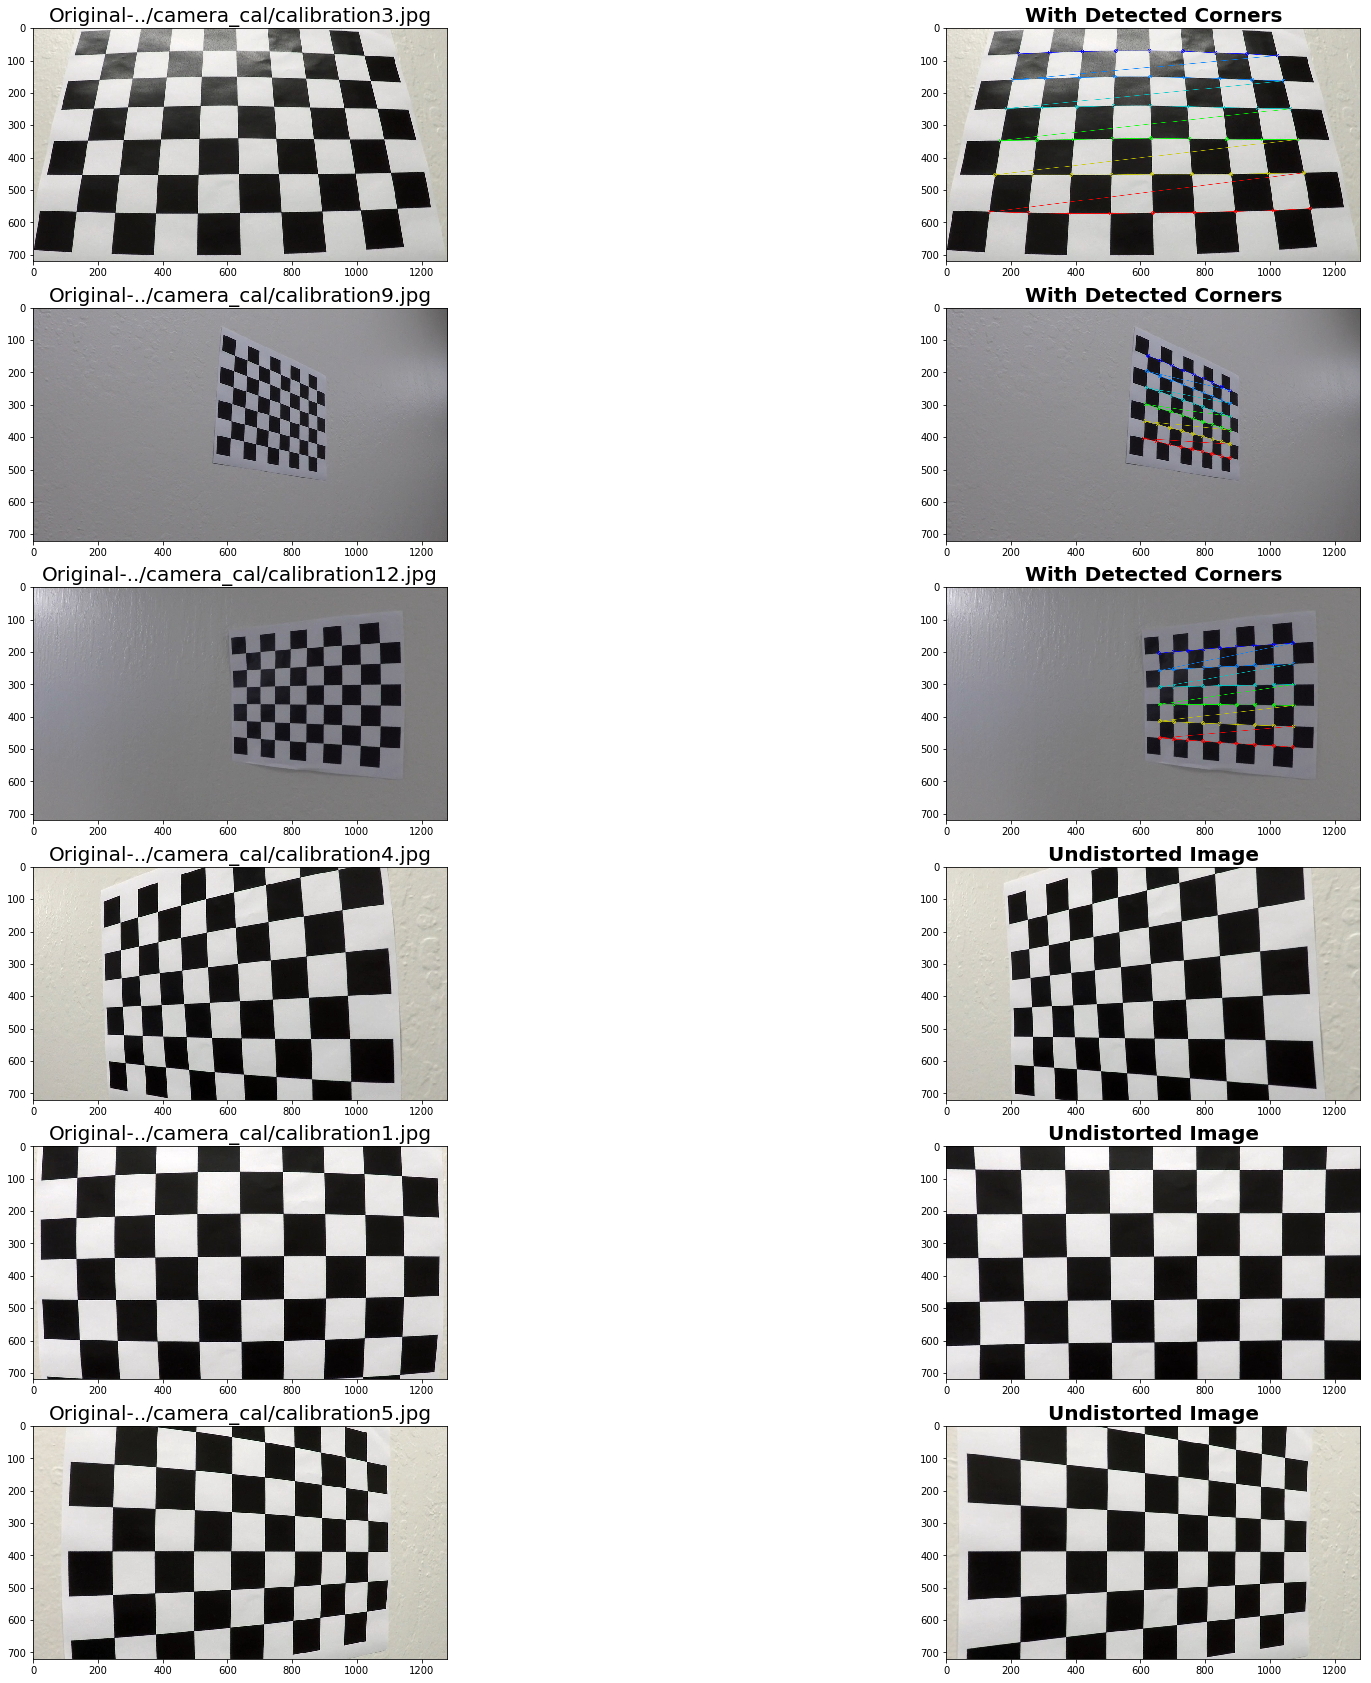

In [16]:
#cleanupOutputFiles()
autoscroll_starting_threshold=-1
paramInstance, lineInstance, testImagesInstance, cameraMatrix, distortionCoeff = initialize_env()
visualize_calib_images() 

# Test-2: Run the test pipeline on the test images </p>

## Test-2-A: Single View of all images generated by the pipeline in one grid 


No need to call initialize the environment if it has already been called in previous cell
**<p style="color:red"> Note** :</p> The display will take few seconds as it is displaying all the images generated by the pipeline

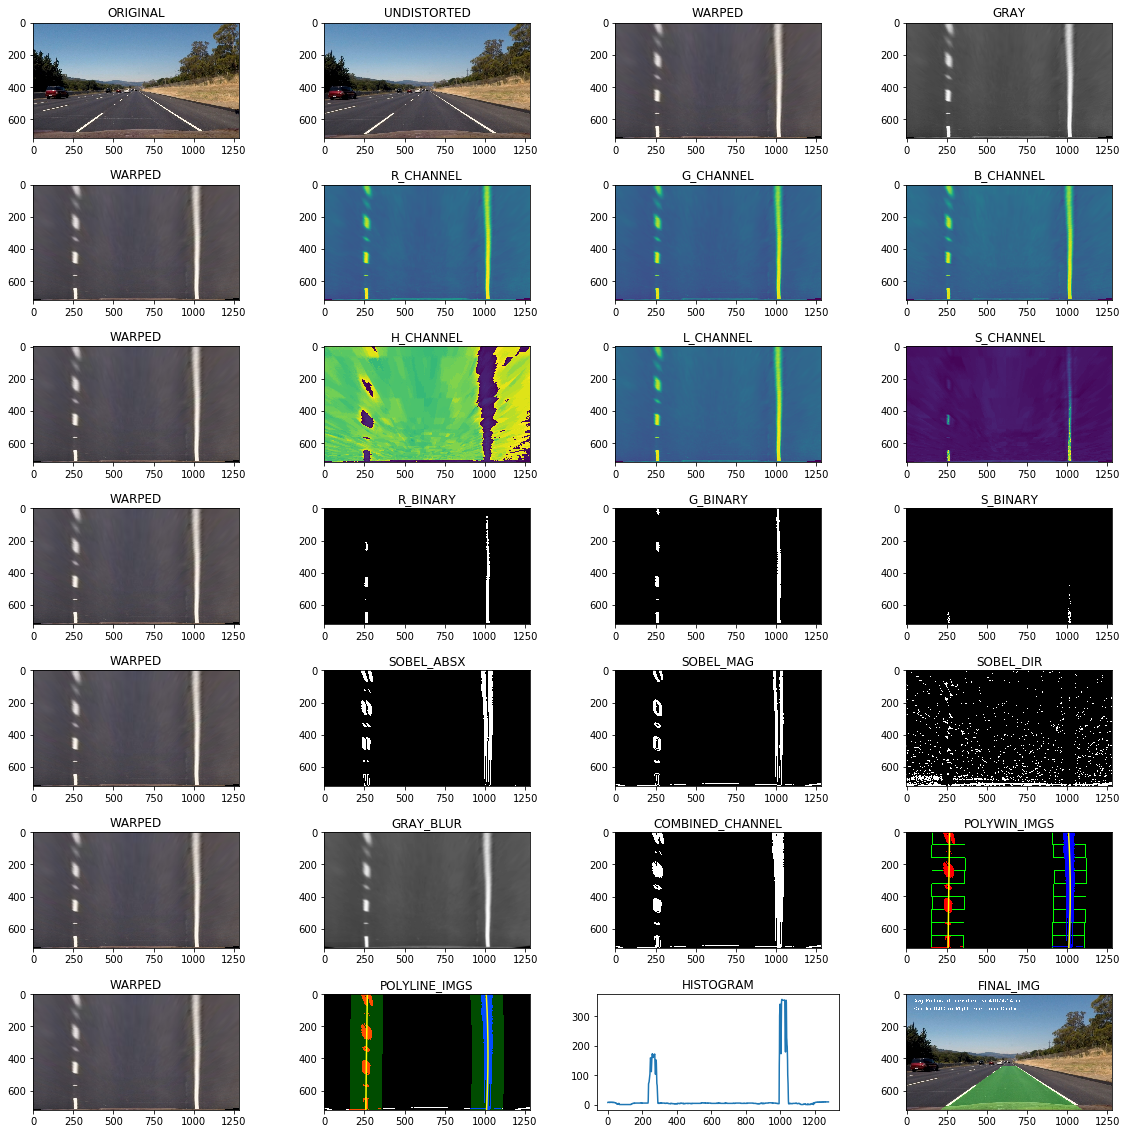

In [17]:

#cleanupOutputFiles()
paramInstance, lineInstance, testImagesInstance, cameraMatrix, distortionCoeff = initialize_env()
test_pipeline(None)  # no argument means the test will run for all test images
visualize_all_test_images("straight_lines2.jpg")  # visualize all the images generated in the pipeline


## Test-2-B: Single test image test run and View individual images generated by each function

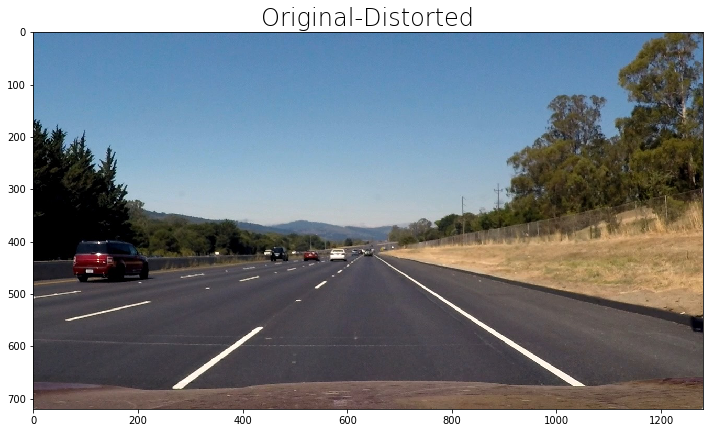

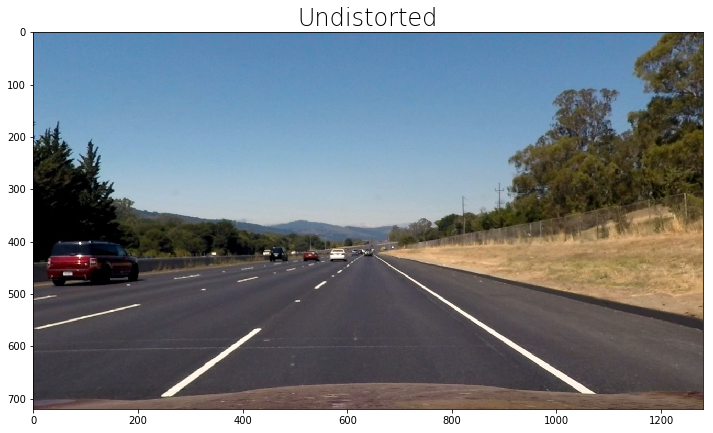

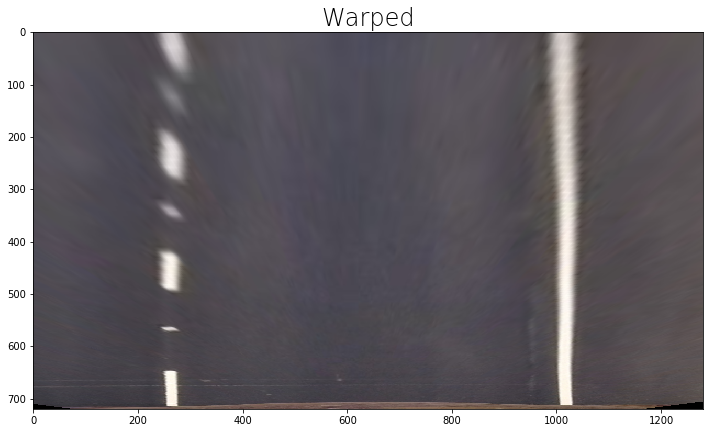

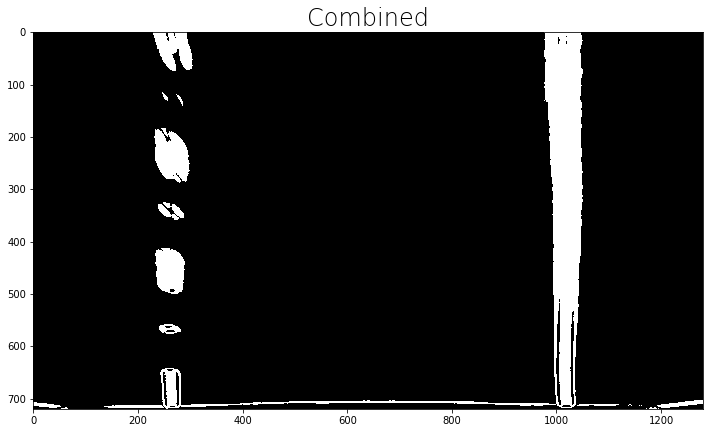

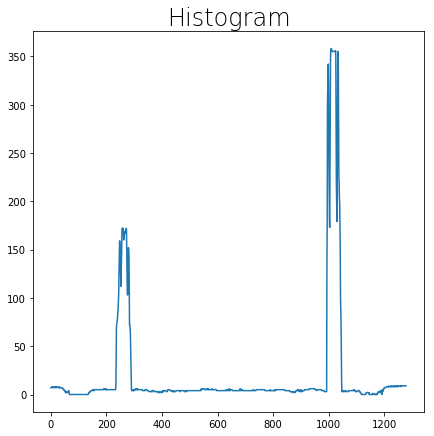

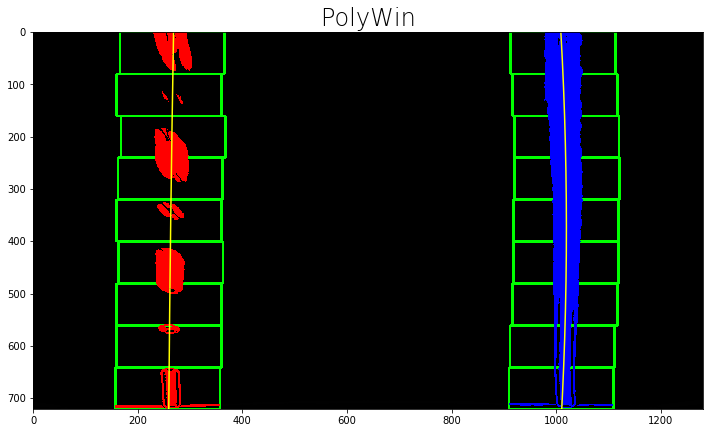

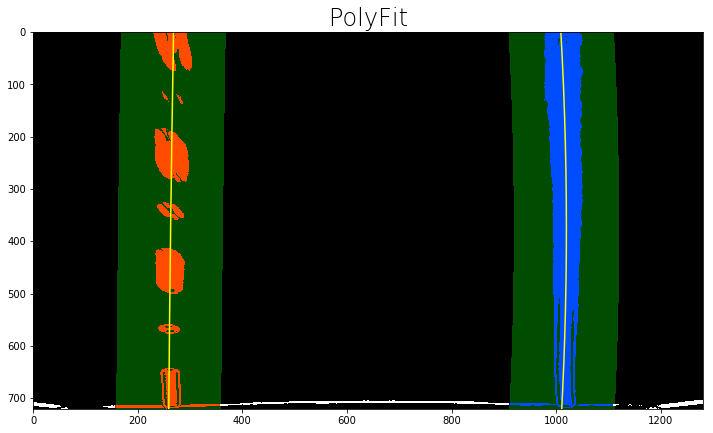

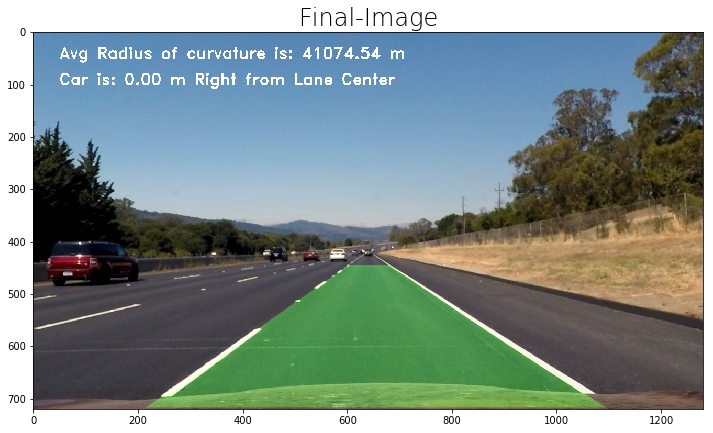

In [60]:
paramInstance, lineInstance, testImagesInstance, cameraMatrix, distortionCoeff = initialize_env()
test_pipeline("straight_lines2.jpg")      # Enter any Test Image Name - All the images are saved in /test_output directory

## Test-2-C: Visualize specific image generated in the test pipeline

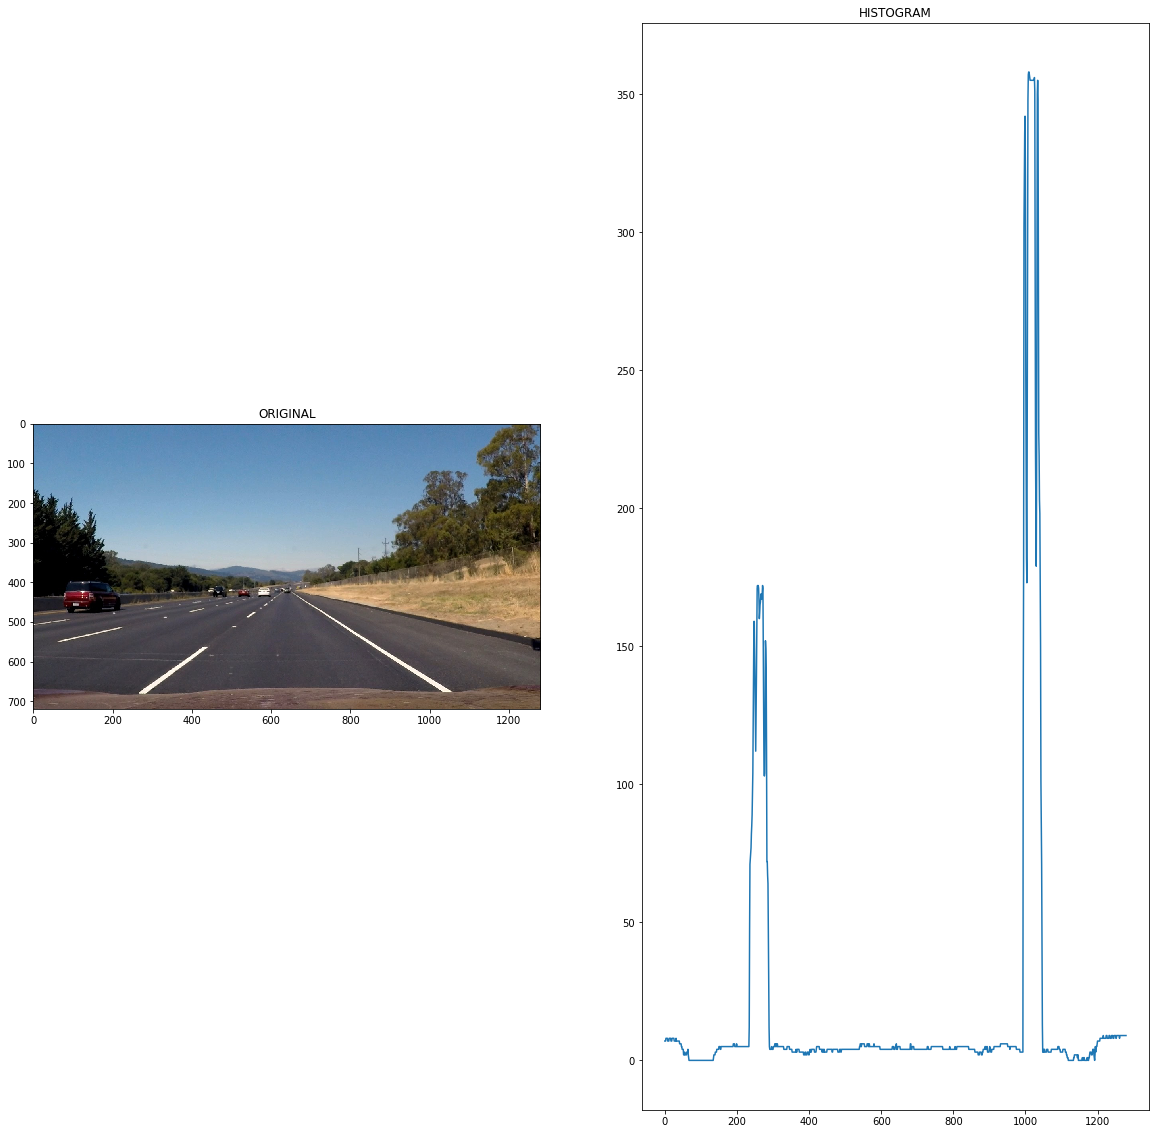

In [54]:
paramInstance, lineInstance, testImagesInstance, cameraMatrix, distortionCoeff = initialize_env()
test_pipeline(None)
visualize_specific_test_images_category("straight_lines2.jpg", "HISTOGRAM") 

# Cleanup the images generated from testing 

In [64]:
cleanupOutputFiles()

# Production Pipeline 

### Run the Algorithm against the real video

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [31]:
cleanupOutputFiles()
paramInstance, lineInstance, testImagesInstance, cameraMatrix, distortionCoeff = initialize_env()
lineInstance.frameCount = 0
def process_image(image):
    mode = "PRODRUN"    #used to toggle between test/prod
    fname = "dummy"   #used in testing, here it act as dummy
    distortedImage = image
    undistortedImage = undistort_image(distortedImage, cameraMatrix, distortionCoeff)
    imgHeight, imgWidth = (undistortedImage.shape[0], undistortedImage.shape[1])
    imgSize_YX =  (imgHeight, imgWidth)
    imgSize_XY =  (imgWidth,imgHeight)
    ploty = np.linspace(0, imgHeight-1, imgHeight)
    M, MInv = tranformation_matrices(imgSize_YX, paramInstance, "TRANFORMATION_MATRICES")
    warpedImage = topview_perspective_transform(undistortedImage, M, imgSize_XY, paramInstance, "TOPVIEW_PERSPECTIVE_TRANSFORM")
    combinedImage = gradient_by_color_and_filter(fname, warpedImage, paramInstance, "GRADIENT_BY_COLOR_AND_FILTER", testImagesInstance, mode)
    polyfitData, pixelPositions, histogram, out_img_1, out_img_2 = initial_fit_polynomial(fname, combinedImage, ploty, paramInstance, "INITIAL_FIT_POLYNOMIAL", testImagesInstance, mode) 
    fitData = (polyfitData[0], polyfitData[1])     # left_fit, right_fit => coefficients
    fitXData = (polyfitData[2], polyfitData[3])    # left_fitx , right_fitx => pixelCoordinates
    curvatureData = measure_curvature_real(ploty, imgWidth, fitData, paramInstance, "MEASURE_CURVATURE_REAL" )   
    finalImg = draw_final_lanes(undistortedImage, combinedImage, imgSize_XY, MInv, ploty, fitXData, curvatureData, paramInstance, "DRAW_FINAL_LANES" )
    return finalImg

In [32]:
import moviepy
from moviepy.editor import VideoFileClip
#initialize_env() sets the global environment
cleanupOutputFiles()
paramInstance, lineInstance, testImagesInstance, cameraMatrix, distortionCoeff = initialize_env()
lineInstance.frameCount = 0
white_output = '../test_videos_output/project_video.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video ../test_videos_output/project_video.mp4
[MoviePy] Writing video ../test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [05:51<00:00,  3.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/project_video.mp4 

CPU times: user 3min 38s, sys: 3.03 s, total: 3min 41s
Wall time: 5min 54s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [35]:
myclip = VideoFileClip("../test_videos_output/project_video.mp4")
myclip.write_gif("test.gif")


[MoviePy] Building file test.gif with imageio


100%|█████████▉| 1260/1261 [08:11<00:00,  3.02it/s]


In [ ]:
# Below code is still under test
# This attemp it to use the previous frames polyfit data and average it to use it for the next frame

cleanupOutputFiles()
paramInstance, lineInstance, testImagesInstance, cameraMatrix, distortionCoeff = initialize_env()
lineInstance.frameCount = 0
def process_image_future(image):
    mode = "PRODRUN"
    fname = "dummy"
    distortedImage = image
    undistortedImage = undistort_image(distortedImage, cameraMatrix, distortionCoeff)
    imgHeight, imgWidth = (undistortedImage.shape[0], undistortedImage.shape[1])
    imgSize_YX =  (imgHeight, imgWidth)
    imgSize_XY =  (imgWidth,imgHeight)
    ploty = np.linspace(0, imgHeight-1, imgHeight)
    M, MInv = tranformation_matrices(imgSize_YX, paramInstance, "TRANFORMATION_MATRICES")
    
    warpedImage = topview_perspective_transform(undistortedImage, M, imgSize_XY, paramInstance, "TOPVIEW_PERSPECTIVE_TRANSFORM")
    combinedImage = gradient_by_color_and_filter(fname, warpedImage, paramInstance, "GRADIENT_BY_COLOR_AND_FILTER", testImagesInstance, mode)
    
    if lineInstance.frameCount == 0 or lineInstance.badFrames >= 10:
        lineInstance.badFrames = 0
        polyfitData, pixelPositions, histogram, out_img_1, out_img_2 = initial_fit_polynomial(fname, combinedImage, ploty, paramInstance, "INITIAL_FIT_POLYNOMIAL", testImagesInstance, mode) 
    else:
        AvgfitData = (lineInstance.polyfitDataAvg[0], lineInstance.polyfitDataAvg[1]) 
        polyfitData, pixelPositions = fitpoly_using_priorfit(fname, combinedImage, ploty, AvgfitData, paramInstance, "FITPOLY_USING_PRIORFIT",testImagesInstance, mode )
    
    fitData = (polyfitData[0], polyfitData[1])     # left_fit, right_fit => coefficients
    fitXData = (polyfitData[2], polyfitData[3])    # left_fitx , right_fitx => pixelCoordinates
       
    curvatureData = measure_curvature_real(ploty, imgWidth, fitData, paramInstance, "MEASURE_CURVATURE_REAL" )   
    laneDetected, sanityCheckDict = perform_sanity_check(fname, polyfitData, curvatureData, lineInstance)
    #update_lineInstance(polyfitData, pixelPositions, curvatureData, laneDetected, sanityCheckDict , lineInstance)
    update_lineInstance(polyfitData, pixelPositions, curvatureData, True, sanityCheckDict , lineInstance)
    finalImg = draw_final_lanes(undistortedImage, combinedImage, imgSize_XY, MInv, ploty, fitXData, curvatureData, paramInstance, "DRAW_FINAL_LANES" )
    
    #if laneDetected and lineInstance.badFrames < 10:
    #    previousImage = finalImg
    #    return finalImg
    #else:
    #    finalImg = previousImage
        
    return finalImg